In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.misc import imread
import tensorflow as tf
import csv

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
voc_classes = ['Hold']
NUM_CLASSES = len(voc_classes) + 2

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights.99-2.40.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [4]:
inputs = []
images = []

img_path = './hold_pinakuru2/IMG_9518.JPG'
img = cv2.imread(img_path)
# img_resize = cv2.resize(img, (2100, 2700))
img_resize = cv2.resize(img, (1500, 2700))
# cv2.imshow("picture",img_resize)
# cv2.waitKey()
# cv2.destroyAllWindows()

h, w, c = img_resize.shape
v_split = 9  # 垂直方向の分割数
h_split = 5  # 水平方向の分割数

# 均等に分割できないと np.spllt() が使えないので、
# 除算したときに余りがでないように画像の端数を切り捨てる
_img = img_resize[:h // v_split * v_split, :w // h_split * h_split]
# print('{} -> {}'.format(img_resize.shape, _img.shape))  # (167, 292, 3) -> (164, 161, 3)

# 分割する
out_imgs = []
for h_img in np.vsplit(_img, v_split):  # 垂直方向に分割する。
    for v_img in np.hsplit(h_img, h_split):  # 水平方向に分割する。
        out_imgs.append(v_img)
out_imgs = np.array(out_imgs, dtype = np.float64)
# print(out_imgs.shape)  # (72, 24, 24, 3)

# img_path = './hold_pinakuru2/IMG_94991.JPG'
# img = image.load_img(img_path, target_size=(300, 300))
# img = image.img_to_array(img)
# images.append(imread(img_path))
images = np.array(out_imgs)
# inputs.append(img.copy())

# inputs = preprocess_input(np.array(inputs))
inputs = preprocess_input(out_imgs)


In [5]:
preds = model.predict(inputs, batch_size=1, verbose=1)

45/45 [==============================] - 53s    


In [6]:
results = bbox_util.detection_out(preds)

In [7]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

Wall time: 50.7 s


1枚目
2枚目
3枚目
center_x = 796.0, center_y = 246.0
p1_x = 829, p1_y = 202
p2_x = 763, p2_y = 202
p3_x = 763, p3_y = 290
p4_x = 829, p4_y = 290
center_x = 678.5, center_y = 104.0
p1_x = 715, p1_y = 53
p2_x = 642, p2_y = 53
p3_x = 642, p3_y = 155
p4_x = 715, p4_y = 155
4枚目
center_x = 1048.0, center_y = 233.0
p1_x = 1092, p1_y = 182
p2_x = 1004, p2_y = 182
p3_x = 1004, p3_y = 284
p4_x = 1092, p4_y = 284
5枚目
center_x = 1390.0, center_y = 116.5
p1_x = 1413, p1_y = 75
p2_x = 1367, p2_y = 75
p3_x = 1367, p3_y = 158
p4_x = 1413, p4_y = 158
6枚目
center_x = 77.0, center_y = 554.0
p1_x = 111, p1_y = 517
p2_x = 43, p2_y = 517
p3_x = 43, p3_y = 591
p4_x = 111, p4_y = 591
center_x = 196.0, center_y = 400.0
p1_x = 224, p1_y = 371
p2_x = 168, p2_y = 371
p3_x = 168, p3_y = 429
p4_x = 224, p4_y = 429
7枚目
center_x = 320.0, center_y = 547.0
p1_x = 338, p1_y = 506
p2_x = 302, p2_y = 506
p3_x = 302, p3_y = 588
p4_x = 338, p4_y = 588
8枚目
center_x = 797.5, center_y = 524.0
p1_x = 843, p1_y = 486
p2_x = 752, p2_y =

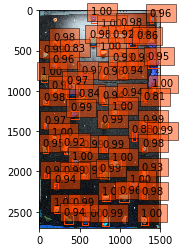

In [8]:
total_conf = []
total_label_indices = []
total_xmin = []
total_ymin = []
total_xmax = []
total_ymax = []

for i, img in enumerate(images):
    print(str(i+1)+"枚目")
# for i in range(6):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]
    
#     print(results[i])
    
    shift_x = (i % 5) * 300
    shift_y = int(i / 5) * 300

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.8]
    
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    
#     print("xmin")
#     print(top_xmin)
#     print("ymin")
#     print(top_ymin)
#     print("xmax")
#     print(top_xmax)
#     print("ymax")
#     print(top_ymax)
#     print(shift_x)
#     print(shift_y)
    
#     if top_xmin > 600 or top_xmin < 0:
#         top_conf = 0
#     if top_xmax > 600 or top_xmax < 0:
#         top_conf = 0
#     elif top_ymin > 900 or top_ymin < 0:
#         top_conf = 0
#     if top_ymin > 900 or top_ymin < 0:
#         top_conf = 0
    total_conf.append(top_conf)
    total_label_indices.append(top_label_indices)
    total_xmin.append(top_xmin)
    total_ymin.append(top_ymin)
    total_xmax.append(top_xmax)
    total_ymax.append(top_ymax)

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
#     plt.figure(figsize = (700, 1000))
#     gs = gridspec.GridSpec(3,2)
#     if (i % 2 == 0):
#         plt.subplot(gs[i, 0])
#         plt.imshow(img[i] / 255.)
        
#     elif (i % 2 == 1):
#         plt.subplot(gs[i, 1])
#         plt.imshow(img[i] / 255.)
    
    plt.imshow(img_resize / 255.)
    currentAxis = plt.gca()

# total_conf = np.array(total_conf)
# total_label_indices = np.array(total_label_indices)
# total_xmin = np.array(total_xmin)
# total_ymin = np.array(total_ymin)
# total_xmax = np.array(total_xmax)
# total_ymax = np.array(total_ymax)

    if(i == 0):
        with open('pi_9518.csv', 'w', newline='') as csv_file:
            fieldnames = ['centerx', 'centery', 'p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
    elif(i > 1):
        with open('pi_9518.csv', 'a', newline='') as csv_file:
            fieldnames = ['centerx', 'centery', 'p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#             writer.writeheader()
    #         print("total_conf = " + str(total_conf.shape))
    #         print("total_xmin = " + str(total_xmin.shape))
    #         print("top_xmin = " + str(top_xmin.shape))

            for j in range(top_conf.shape[0]):
                xmin = int(round(top_xmin[j] * img.shape[1]))+shift_x
                ymin = int(round(top_ymin[j] * img.shape[0]))+shift_y
                xmax = int(round(top_xmax[j] * img.shape[1]))+shift_x
                ymax = int(round(top_ymax[j] * img.shape[0]))+shift_y
                score = top_conf[j]
                label = int(top_label_indices[j])
                label_name = voc_classes[label - 1]
            #   display_txt = '{:0.2f}, {}'.format(score, label_name)
                display_txt = '{:0.2f}'.format(score)
                coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
                color = colors[label]
                currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=1))
                currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
        #         if(i >= 25): #大きすぎると動かない
        #             break


        #     for i in range(top_conf.shape[0]):
        #         xmin = int(round(top_xmin[i] * img.shape[1]))
        #         ymin = int(round(top_ymin[i] * img.shape[0]))
        #         xmax = int(round(top_xmax[i] * img.shape[1]))
        #         ymax = int(round(top_ymax[i] * img.shape[0]))
        #         score = top_conf[i]
        #         label = int(top_label_indices[i])
        #         label_name = voc_classes[label - 1]
        #         display_txt = '{:0.2f}, {}'.format(score, label_name)
        #         coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        #         color = colors[label]
        #         currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #         currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
                centerx = (xmin + xmax)/2
                centery = (ymin + ymax)/2

                writer.writerow({'centerx': str(centerx), 'centery': str(centery), 'p1_x': str(xmax), 'p1_y': str(ymin), 'p2_x': str(xmin), 'p2_y': str(ymin), 'p3_x': str(xmin), 'p3_y': str(ymax), 'p4_x': str(xmax), 'p4_y': str(ymax)})

                print("center_x = " + str(centerx) + ", center_y = " + str(centery))
                print("p1_x = " + str(xmax) + ", p1_y = " + str(ymin))
                print("p2_x = " + str(xmin) + ", p2_y = " + str(ymin))
                print("p3_x = " + str(xmin) + ", p3_y = " + str(ymax))
                print("p4_x = " + str(xmax) + ", p4_y = " + str(ymax))
    #         plt.show() #表示できないからコメントアウト
            plt.savefig('out_wall' + '.png')